In [10]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dask
import xarray as xr
from dask.diagnostics import ProgressBar

import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

#from dask_ml.xgboost import XGBRegressor
#from dask_ml.linear_model import LogisticRegression
from dask_ml.linear_model import LinearRegression

import keras
from keras.layers.core import Dropout

ModuleNotFoundError: No module named 'keras'

In [11]:
import sys
print(sys.executable)

/home/srvx11/lehre/users/a1303583/.conda/envs/py3/bin/python


In [ ]:
def shift_time(ds, value):
    ds.coords['time'].values = pd.to_datetime(ds.coords['time'].values) + value
    return ds

In [ ]:
static = xr.open_dataset('../data/usa/era5_slt_z_slor_lsm_stationary_field.nc')

In [ ]:
era5 = xr.open_dataset('../data/usa/era5_lsp_cp_1981-2017_daysum.nc')

In [ ]:
glofas = xr.open_dataset('../data/usa/glofas_reanalysis_usa_1981-2002.nc')
glofas = glofas.rename({'lat': 'latitude', 'lon': 'longitude'})  # to have the same name like in era5
glofas = shift_time(glofas, -dt.timedelta(days=1))
# da.transpose(dims='latitude')  # flip?

In [ ]:
glofas = glofas.isel(time=slice(0, 365*3))

### basic spatial subset - compute the model only in this domain

In [8]:
box_model = dict(latitude=slice(40, 28), 
                 longitude=slice(-95, -85))

In [9]:
glofas = glofas.sel(box_model)
era5 = era5.sel(box_model)

In [10]:
dis = glofas['dis']

In [11]:
z_glofas = static['z'].isel(time=0)/9.81  # converting to m approx.
z_glofas = z_glofas.interp(latitude=glofas.latitude,
                           longitude=glofas.longitude)
z_glofas = z_glofas.drop('time')  # time is misleading as the topography does not change

In [12]:
tp = (era5['cp']+era5['lsp'])*1000
tp.name = 'total precip [mm]'
tp = tp.interp(latitude=glofas.latitude,
               longitude=glofas.longitude)

# Preprocessing routines - Summary

In [13]:
def add_shifted_predictors(ds, shifts, variables='all'):
    """Adds additional variables to an array which are shifted in time.
    
    Parameters
    ----------
    ds : xr.Dataset
    shifts : list of integers
    variables : str or list
    """
    if variables == 'all': 
        variables = ds.data_vars
        
    for var in variables:
        for i in shifts:
            if i == 0: continue  # makes no sense to shift by zero
            newvar = var+'-'+str(i)
            ds[newvar] = ds[var].shift(time=i)
    return ds

In [14]:
def correlate(da_3d, da_timeseries, timelag=False):
    a = da_3d - da_3d.mean('time')
    b = da_timeseries - da_timeseries.mean('time')
    N = len(b.coords['time'])
    if timelag:
        b = b.drop('time')
        a = a.drop('time')
    out = b.dot(a)/a.std('time')/b.std()/N
    out.name = 'correlation coefficient'
    return out

In [15]:
def select_river(dis):
    river = dis.min('time') > 5
    river.name = 'river mask [0/1]'
    return river

In [16]:
def select_upstream_river(dis_box, dis_point, z_box, z_point, rivermask, pct):
    lags = [-1, 1]

    timelag_corrs = np.full((len(lags), len(dis_box.latitude), len(dis_box.longitude)), np.nan)
    for t, lag in enumerate(lags):
        if lag > 0:  # dis_box with data from previous timesteps
            cntr = dis_point[lag:]
            dis_box_shift = dis_box[:-lag]
        elif lag < 0:  # dis_box with data from future timesteps
            cntr = dis_point[:lag]
            dis_box_shift = dis_box[-lag:]

        dis_box_relevant = dis_box_shift.where(rivermask==1)
        timelag_corrs[t,:,:] = correlate(dis_box_relevant, cntr, timelag=True)

    lag_influencing = timelag_corrs[1,:,:]>timelag_corrs[0,:,:]
    #plt.imshow(lag_influencing)

    influencer = (dis_box.mean('time') > pct*dis_point.mean('time'))  \
                  &(z_box > z_point)   \
                  &(rivermask==1) & lag_influencing
    influencer.name = 'gridpoints influencing discharge [0/1]'
    #influencer.plot()
    return influencer

In [17]:
shifts = range(1,4)
X_dis = add_shifted_predictors(glofas, shifts, variables='all')
X_dis = X_dis.drop('dis')  # we actually want to predict (t) with (t-1, t-2, t-3)
y_dis = glofas['dis']

In [18]:
i, j = 70, 38
di = 20
dj = 20
pct = 0.1  # influencing gridpoint must have mean discharge more than this percentage

i0, i1 = i-di, i+di
j0, j1 = j-dj, j+dj

In [19]:
tp_box = tp[:, i0:i1, j0:j1]
few_precip = tp_box.mean(['longitude', 'latitude']) < 0.1
print('percentage:',sum(few_precip.astype(int))/few_precip.size) # .plot() #.plot() #'#'
print(few_precip)

percentage: <xarray.DataArray 'total precip [mm]' ()>
array(0.334986)
<xarray.DataArray 'total precip [mm]' (time: 13514)>
array([ True,  True,  True, ...,  True, False, False])
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01T23:00:00 ... 2017-12-31T23:00:00


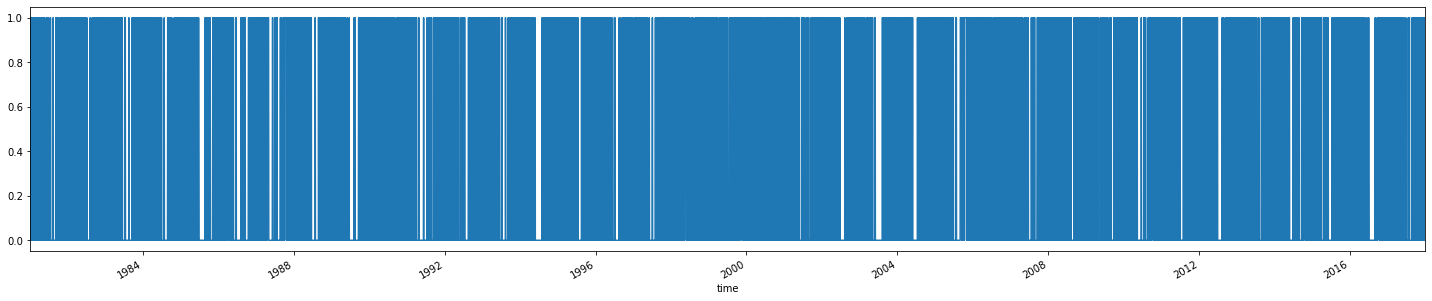

In [20]:
fig, ax = plt.subplots(figsize=(25,5))
few_precip.astype(int).to_pandas().plot(ax=ax)

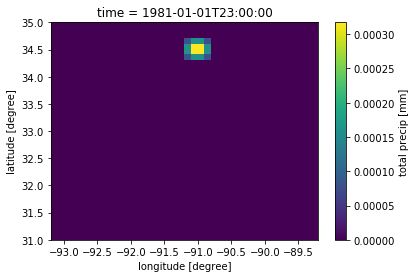

In [21]:
tp_box.where(few_precip).isel(time=0).plot()

In [22]:
dis = dis.load()
disf = dis.where(few_precip)

In [23]:
dis

<xarray.DataArray 'dis' (time: 1095, latitude: 120, longitude: 100)>
array([[[9.030977e-02, 6.938147e-02, ..., 1.058031e+00, 7.581121e-01],
        [4.353719e+02, 6.850996e-02, ..., 1.591652e+00, 9.349488e-01],
        ...,
        [         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan]],

       [[8.804606e-02, 6.719401e-02, ..., 1.058679e+00, 7.594556e-01],
        [4.354823e+02, 6.682967e-02, ..., 1.589289e+00, 9.351913e-01],
        ...,
        [         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan]],

       ...,

       [[4.729932e-01, 4.863705e-01, ..., 1.142748e+00, 8.647016e-01],
        [7.267107e+02, 3.798618e-01, ..., 2.813933e+00, 1.405810e+00],
        ...,
        [         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan]],

       [[4.714040e-01

### pre-selection of upstream river gridpoints

In [24]:
dis_point = dis[:,i,j]
dis_box = dis[:, i0:i1, j0:j1]
z_point = z_glofas[i,j]
z_box = z_glofas[i0:i1,j0:j1]


rivermask = select_river(dis_box)

upstream = select_upstream_river(dis_box, dis_point, z_box, z_point, rivermask, pct)

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<xarray.DataArray 'gridpoints influencing discharge [0/1]' ()>
array(26)


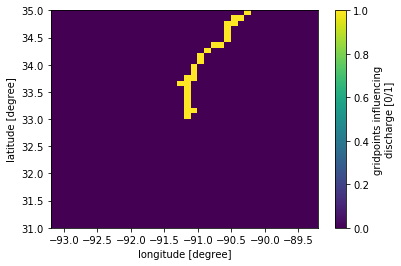

In [25]:
upstream.plot()
print(upstream.sum())

# Parameter-tuning for reasonable performance

In [26]:
def preprocess_reshape(X_dis, y_dis, upstream, i, j):
    X_dis = X_dis.where(upstream)
    X_dis = X_dis.to_array(dim='time_feature')  
    X_dis = X_dis.stack(features=['latitude', 'longitude', 'time_feature'])
    Xar = X_dis.dropna('features', how='all')
    
    yar = y_dis[:,i,j]
    yar = yar.drop(['latitude', 'longitude'])
    yar.coords['features'] = 'dis'
    
    Xy = xr.concat([Xar, yar], dim='features')
    Xyt = Xy.dropna('time', how='any')  # drop them as we cannot train on nan values
    time = Xyt.time
    
    Xda = Xyt[:,:-1]
    yda = Xyt[:,-1]
    return Xda, yda, time

In [27]:
Xda, yda, time = preprocess_reshape(X_dis, y_dis, upstream, i,j)

In [28]:
Xda

<xarray.DataArray (time: 1092, features: 78)>
array([[ 4151.1094,  4166.663 ,  4182.    , ...,  4820.8086,  4847.2827,
         4875.5356],
       [ 4134.447 ,  4151.1094,  4166.663 , ...,  4795.667 ,  4820.8086,
         4847.2827],
       [ 4117.834 ,  4134.447 ,  4151.1094, ...,  4772.7407,  4795.667 ,
         4820.8086],
       ...,
       [10176.239 , 10166.683 , 10201.387 , ..., 11792.947 , 11961.535 ,
        12160.183 ],
       [10226.457 , 10176.239 , 10166.683 , ..., 11665.72  , 11792.947 ,
        11961.535 ],
       [10286.518 , 10226.457 , 10176.239 , ..., 11585.135 , 11665.72  ,
        11792.947 ]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1981-01-04 1981-01-05 ... 1983-12-31
  * features  (features) object (34.95, -90.24999999999999, 'dis-1') ... (33.05, -91.14999999999998, 'dis-3')

In [29]:
X_dis.where(upstream) #.plot()

<xarray.Dataset>
Dimensions:    (latitude: 40, longitude: 40, time: 1095)
Coordinates:
  * latitude   (latitude) float64 34.95 34.85 34.75 34.65 ... 31.25 31.15 31.05
  * longitude  (longitude) float64 -93.15 -93.05 -92.95 ... -89.45 -89.35 -89.25
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1983-12-31
Data variables:
    dis-1      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    dis-2      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    dis-3      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.6.4rc4 (http://code.zmaw.d...
    Conventions:  CF-1.4
    history:      Thu Jun 13 19:39:24 2019: cdo mergetime /home/srvx11/lehre/...
    CDO:          Climate Data Operators version 1.6.4rc7 (http://code.zmaw.d...

In [30]:
Xda = Xda.values
yda = yda.values[:, np.newaxis]

In [31]:
print('yda.shape:', Xda.shape, 'yda.shape:',  yda.shape)

yda.shape: (1092, 78) yda.shape: (1092, 1)


In [32]:
class KerasDenseNN(object):
    def __init__(self, **kwargs):
        model = keras.models.Sequential()
        self.cfg = kwargs
        
        model.add(keras.layers.BatchNormalization())
        
        model.add(keras.layers.Dense(8,
                                  kernel_initializer='normal', 
                                  bias_initializer='zeros',
                                  activation='relu')) #('sigmoid'))
        #model.add(Dropout(self.cfg.get('dropout')))
        #model.add(keras.layers.Dense(32))
        #model.add(keras.layers.Activation('sigmoid'))
        #model.add(Dropout(self.cfg.get('dropout')))
        #model.add(keras.layers.Dense(16))
        #model.add(keras.layers.Activation('sigmoid'))
        #model.add(Dropout(self.cfg.get('dropout')))
        #model.add(keras.layers.Dense(8))
        #model.add(keras.layers.Activation('sigmoid'))
        #model.add(Dropout(self.cfg.get('dropout')))
        model.add(keras.layers.Dense(1, activation='linear'))
        #                     bias_initializer=keras.initializers.Constant(value=9000)))
        
        #ha = self.cfg.get('hidden_activation')

        #for N_nodes in self.cfg.get('N_hidden_nodes'):
        #        
        #    model.add(hidden)
        #    model.add(ha.copy())
        #    
        #    if self.cfg.get('dropout'):
        #        model.add(Dropout(self.cfg.get('dropout')))#

        #outputlayer = keras.layers.Dense(1, activation='linear')

        #optimizer_name, options_dict = self.cfg.get('optimizer')
        #optimizer = getattr(keras.optimizers, optimizer_name)(**options_dict)
        #optimizer = keras.optimizers.SGD(lr=0.01)
        rmsprop = keras.optimizers.RMSprop(lr=.1)
        sgd = keras.optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.5, nesterov=True)

        model.compile(loss=self.cfg.get('loss'), 
                      optimizer=rmsprop)
        self.model = model

        self.callbacks = [keras.callbacks.EarlyStopping(monitor='loss',
                            min_delta=1, patience=100, verbose=0, mode='auto',
                            baseline=None, restore_best_weights=True),]

    def predict(self, X):
        return self.model.predict(X).squeeze()

    def fit(self, X, y, **kwargs):
        return self.model.fit(X, y,
                              epochs=self.cfg.get('epochs', None),
                              batch_size=self.cfg.get('batch_size', None),
                              callbacks=self.callbacks,
                              verbose=1,
                              **kwargs)
    
    

In [33]:

mlp_kws = dict(optimizer=('sgd', dict(lr=1)),
               loss='mean_squared_error',
               #N_hidden_nodes=(4,4),
               #hidden_activation=keras.layers.Activation('sigmoid'), #keras.layers.ReLU(), #-LeakyReLU(alpha=0.3), #'relu',
               #output_activation='linear',
               #bias_initializer='random_uniform',
               batch_size=128,
               dropout=0., #.25,
               epochs=1000,
              )


linear_kws = dict(C=.1, n_jobs=-1, max_iter=10000, verbose=True)


if False:
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('pca', PCA(n_components=4)),
                     ('model', LinearRegression(**linear_kws)),],
                    verbose=True)
if True:
    pipe = Pipeline([#('scaler', StandardScaler()),
                     #('pca', PCA(n_components=2)),
                     ('model', KerasDenseNN(**mlp_kws)),],
                    verbose=False)
    

In [34]:
pipe

Pipeline(memory=None,
         steps=[('model', <__main__.KerasDenseNN object at 0x7f206da483c8>)],
         verbose=False)

In [35]:
type(Xda)

numpy.ndarray

In [36]:
history = pipe.fit(Xda, yda)

Epoch 1/1000
1092/1092 [==============================] - 0s 31us/step - loss: 147108337.1722
Epoch 2/1000
1092/1092 [==============================] - 0s 11us/step - loss: 98884458.0806
Epoch 3/1000
1092/1092 [==============================] - 0s 11us/step - loss: 57823935.6630
Epoch 4/1000
1092/1092 [==============================] - 0s 10us/step - loss: 42240299.8535
Epoch 5/1000
1092/1092 [==============================] - 0s 10us/step - loss: 32537950.1538
Epoch 6/1000
1092/1092 [==============================] - 0s 11us/step - loss: 13889310.7363
Epoch 7/1000
1092/1092 [==============================] - 0s 11us/step - loss: 2492459.5826
Epoch 8/1000
1092/1092 [==============================] - 0s 11us/step - loss: 2238356.1287
Epoch 9/1000
1092/1092 [==============================] - 0s 10us/step - loss: 2575206.5096
Epoch 10/1000
1092/1092 [==============================] - 0s 11us/step - loss: 1045738.2692
Epoch 11/1000
1092/1092 [==============================] - 0s 10us/step 

1092/1092 [==============================] - 0s 9us/step - loss: 729280.3581
Epoch 178/1000
1092/1092 [==============================] - 0s 8us/step - loss: 1528655.4748
Epoch 179/1000
1092/1092 [==============================] - 0s 8us/step - loss: 968060.6536
Epoch 180/1000
1092/1092 [==============================] - 0s 8us/step - loss: 749848.0009
Epoch 181/1000
1092/1092 [==============================] - 0s 8us/step - loss: 1343951.4455
Epoch 182/1000
1092/1092 [==============================] - 0s 8us/step - loss: 1562069.0432
Epoch 183/1000
1092/1092 [==============================] - 0s 8us/step - loss: 731810.0897
Epoch 184/1000
1092/1092 [==============================] - 0s 8us/step - loss: 1248269.3787
Epoch 185/1000
1092/1092 [==============================] - 0s 8us/step - loss: 1174315.1648
Epoch 186/1000
1092/1092 [==============================] - 0s 8us/step - loss: 2725048.0126
Epoch 187/1000
1092/1092 [==============================] - 0s 8us/step - loss: 465176.62

In [37]:
keras.utils.print_summary(pipe.named_steps['model'].model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 78)                312       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 632       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 953
Trainable params: 797
Non-trainable params: 156
_________________________________________________________________


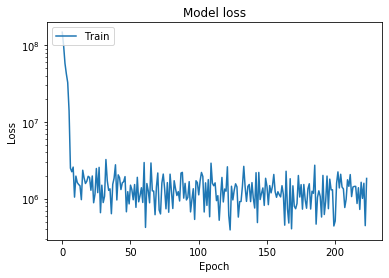

In [38]:
h = history.named_steps['model'].model.history

# Plot training & validation loss values
plt.plot(h.history['loss'])
#plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.gca().set_yscale('log')
plt.show()

# Test it on the same data

In [39]:
def add_time(vector, time, name=None):
    """Converts arrays to xarrays with a time coordinate."""
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

In [40]:
with ProgressBar():
    ytest = pipe.predict(Xda)

In [41]:
ytest.shape

(1092,)

In [42]:
ytest = add_time(ytest, time, name='dis-forecast')
ytest_dis = ytest #.cumsum('time')
ytest_dis.values
#ytest_dis += y[0]  # initial state + changes = timeseries of forecasted discharge

array([ 5237.2803,  5218.1343,  5200.064 , ..., 12453.188 , 12369.984 ,
       12331.721 ], dtype=float32)

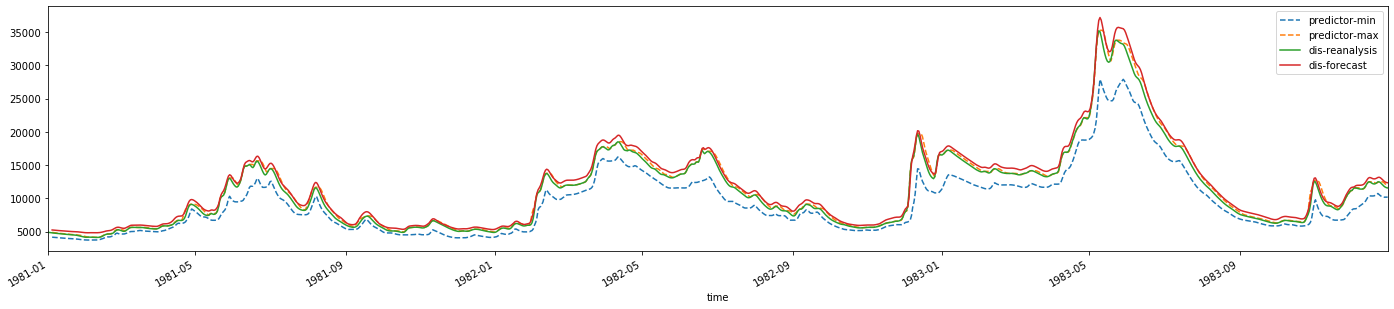

In [43]:
fig, ax = plt.subplots(figsize=(24,5))
#for p in range(Xda.shape[1]):
    #print(p)
    #print(Xda[:,p])
minpred = add_time(Xda.min(axis=1), time)
maxpred = add_time(Xda.max(axis=1), time)

minpred.plot(ax=ax, linestyle='--', label='predictor-min')
maxpred.plot(ax=ax, linestyle='--', label='predictor-max')


obs = dis[:,i,j].to_pandas()
fcst = ytest_dis.to_pandas()
obs.plot(ax=ax, label='dis-reanalysis')
fcst.plot(ax=ax, label='dis-forecast')
plt.legend()
#plt.gca().set_xlim(dt.datetime(1981,1,1), dt.datetime(1982,1,1)) 

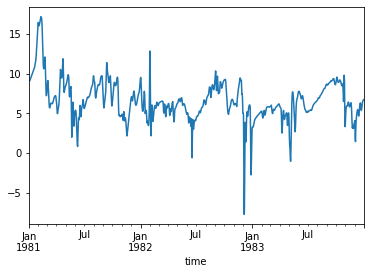

In [44]:
((fcst-obs)/obs*100).plot()

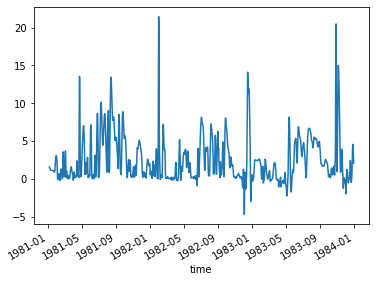

In [45]:
y = add_time(yda.squeeze(), time)
((maxpred-y)/y*100).plot()

In [46]:
s = pipe.named_steps['model'].model.to_json()
import json
with open('flowmodel.json', 'w') as f:
    json.dump(s, f, indent=4)